In [ ]:
!pip install spacy
!python -m spacy download en_core_web_md
!pip install squarify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import spacy
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from math import pi

nlp = spacy.load("en_core_web_md")

In [5]:
df = pd.read_csv('Postings.csv')
def clean_job_title(title):
    # Convert to lowercase to make the matching case-insensitive
    title = title.lower()

    # Otherwise, proceed with cleaning
    # Remove numbers
    title = re.sub(r'\d+', '', title)
    # Remove special characters, keeping only alphabets and spaces
    title = re.sub(r'[^\w\s]', '', title)
    # Remove unnecessary words
    unnecessary_words = [
        'senior', 'junior', 'lead', 'contract', 'months', 'remote', 'level', 'entry'
    ]
    # Split the title into words, filter out unnecessary words, and rejoin
    title_words = title.split()
    title_words = [word for word in title_words if word not in unnecessary_words]
    cleaned_title = ' '.join(title_words)
    job_titles = {
        'data engineer': 'data engineer',
        'data scientist': 'data scientist',
        'software engineer': 'software engineer',
        'analyst': 'analyst',
        'architect': 'architect'
    }

    # Loop through the job_titles dictionary and check if any of the titles exist in the job title
    for key, value in job_titles.items():
        if key in title:
            return value  # Return the exact matched job title

    return cleaned_title

# Apply the cleaning function to the job_title column
df['cleaned_job_title'] = df['job_title'].apply(clean_job_title)

# Check the result
print(df[['job_title', 'cleaned_job_title']].head())


                                      job_title  \
0                               Data Engineer 2   
1                           Staff Data Engineer   
2          Senior Data Engineer, Public Company   
3          Senior Data Engineer, Public Company   
4  Senior Systems Engineer, Azure Data Platform   

                      cleaned_job_title  
0                         data engineer  
1                         data engineer  
2                         data engineer  
3                         data engineer  
4  systems engineer azure data platform  


In [ ]:
df.head()

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills,cleaned_job_title
0,Data Engineer 2,Cook Medical,"Bloomington, IN",https://www.linkedin.com/jobs/view/data-engine...,2023-12-17,Bloomington,United States,Mid senior,Onsite,"Overview\nThe Data Engineer develops, implemen...","Azure, SQL, NoSQL, SQL Server, Oracle, MongoDB...",data engineer
1,Staff Data Engineer,Recruiting from Scratch,"Bloomington, IN",https://www.linkedin.com/jobs/view/staff-data-...,2023-12-17,Bloomington,United States,Mid senior,Onsite,This is for a client of Recruiting from Scratc...,"Python, Snowflake, Airflow, Kubernetes, Docker...",data engineer
2,"Senior Data Engineer, Public Company",Recruiting from Scratch,"Bloomington, IN",https://www.linkedin.com/jobs/view/senior-data...,2023-12-17,Bloomington,United States,Mid senior,Onsite,This is for a client of Recruiting from Scratc...,"Python, SQL, Snowflake, Airflow, Kubernetes, D...",data engineer
3,"Senior Data Engineer, Public Company",Recruiting from Scratch,"Bloomington, IN",https://www.linkedin.com/jobs/view/senior-data...,2023-12-17,Bloomington,United States,Mid senior,Onsite,This is for a client of Recruiting from Scratc...,"TDD, Automation, Continuous delivery, Data eng...",data engineer
4,"Senior Systems Engineer, Azure Data Platform",Cook Medical,"Bloomington, IN",https://www.linkedin.com/jobs/view/senior-syst...,2023-12-17,Bloomington,United States,Mid senior,Hybrid,Overview\nWe are seeking a talented Azure Clou...,NaN,systems engineer azure data platform


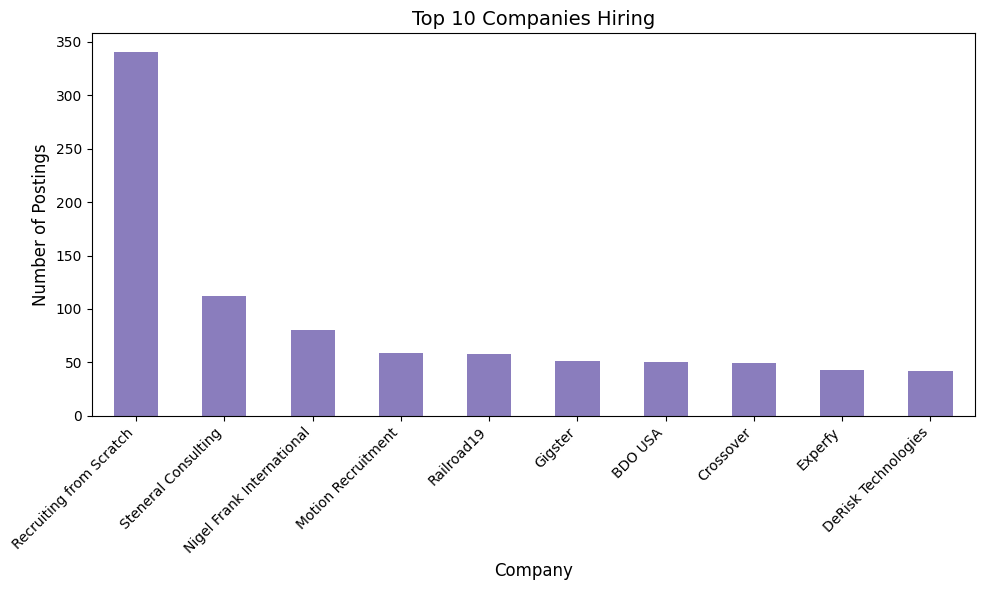

In [6]:
# Use a violet-indigo color
fig, ax = plt.subplots(figsize=(10, 6))  # Create the figure and axes

# Set the background color of the plot area (axes) inside the plot
ax.set_facecolor('none') # Change the plot area (axes) background to light yellow

# Plot the data
df['company'].value_counts().head(10).plot(kind='bar', color='#8A7DBD', ax=ax)  # Violet and Indigo color for bars

# Set title and labels
plt.title('Top 10 Companies Hiring', fontsize=14)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Number of Postings', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
print(len(df['cleaned_job_title'].unique()))

612


In [ ]:
print(len(df['job_title'].unique()))

2566


In [7]:
df['job_summary'] = df['job_summary'].fillna("EDA")

# Common job titles or irrelevant terms to exclude from skills
job_titles = [
    'data engineer', 'data scientist', 'software engineer', 'analyst', 'developer', 'architect', 'manager',
    "bachelor", "develop", "data", "data engineering", "sequoia capital", "lightspeed ventures", "dfj",
    "tiger global management", "scratch", "vision", "data scientists", "dental", "emr", "data science",
    "computer science","senior data engineer"
]

# Function to extract skills based on NER labels and excluding job roles
def extract_skills(text):
    doc = nlp(text)  # Process the text
    skills = []
    for ent in doc.ents:
        # Include entities that are PRODUCT, LANGUAGE, or SKILL but not job titles
        if ent.label_ in ["ORG", "PRODUCT", "LANGUAGE", "SKILL"]:
            skill = ent.text.lower().strip()  # Convert to lowercase and strip whitespace
            if skill not in job_titles:  # Exclude job titles
                skills.append(ent.text)
    return list(set(skills))

# Apply the extraction function to job descriptions
df["extracted_skills"] = df["job_summary"].apply(extract_skills)

# Function to replace specific skills
def replace_skills(skills):
    return [
        "Azure" if skill.lower() == "microsoft" else "Power BI" if skill.lower() == "bi" else skill
        for skill in skills
    ]

# Apply the replacement function to each list in 'extracted_skills'
df["extracted_skills"] = df["extracted_skills"].apply(replace_skills)

# Display the updated extracted skills
print(df["extracted_skills"])


0       [ADA, Hybird, SQL, Physical Requirements\nWork...
1       [Spark-Streaming, ETL, SQL, Recruiting, TDD, C...
2       [Spark-Streaming, ETL, SQL, Recruiting, Python...
3       [Spark-Streaming, ETL, SQL, Recruiting, Python...
4       [ADA, Fabric Data Platform Engineer, Physical ...
                              ...                        
6020    [Procurement KPI, Oracle, Data Analyst, Oracle...
6021    [Project Management, CDO, SQL, SME, Barclays, ...
6022    [Validate, Direct Suppliers, SQL, Business Int...
6023                      [PyTorch, • Thrive, Scikit, AI]
6024    [Mental Health, Curiosity, Financial Services ...
Name: extracted_skills, Length: 6025, dtype: object


In [ ]:
#Flatten the lists of skills
all_skills = [skill for sublist in df['extracted_skills'] for skill in sublist]

# Step 2: Count the unique values
unique_skills_count = pd.Series(all_skills).value_counts()

# Print the unique skills count
print(unique_skills_count)

SQL                               2863
Python                            1807
ETL                               1555
AWS                               1523
Spark                             1196
                                  ... 
Advanced Analytics & AI              1
SDG Group                            1
Product/Clinical/                    1
Business Intelligence, Finance       1
the Cloud Platforms                  1
Name: count, Length: 23932, dtype: int64


In [ ]:
# Step 2: Get the skills that appear more than 10 times
skills_to_keep = unique_skills_count[unique_skills_count > 15].index

# Step 3: Update the 'extracted_skills' column by removing skills that appear less than or equal to 10 times
df['extracted_skills'] = df['extracted_skills'].apply(lambda skills: [skill for skill in skills if skill in skills_to_keep])

In [ ]:
with open("ExplicitStopWords.txt", "r") as f:
    words_to_remove = set(word.strip().strip('"').lower() for word in f.read().split(','))

def remove_words(skill_list):
    return [word for word in skill_list if word.lower() not in words_to_remove]

# Apply the function to each row in the 'extracted_skills' column
df["extracted_skills"] = df["extracted_skills"].apply(lambda x: remove_words(x) if isinstance(x, list) else [])


In [ ]:
# Check if each row has any words that should have been removed
df["words_removed_successfully"] = df["extracted_skills"].apply(
    lambda skills: all(word.lower() not in words_to_remove for word in skills)
)

# Display results
print(df[["extracted_skills", "words_removed_successfully"]])

                                       extracted_skills  \
0                      [Azure, Oracle, SQL Server, SQL]   
1     [Docker, Data Warehouses, S3, Spark, ETL, TDD,...   
2     [Docker, Data Warehouses, S3, Spark, ETL, TDD,...   
3     [Docker, Data Warehouses, S3, Spark, ETL, TDD,...   
4                                       [Azure, DevOps]   
...                                                 ...   
6020                                    [Excel, Oracle]   
6021                                              [SQL]   
6022                                    [Power BI, SQL]   
6023                                      [AI, PyTorch]   
6024  [Spark, DBT, BigQuery, RedShift, PowerBI, Apac...   

      words_removed_successfully  
0                           True  
1                           True  
2                           True  
3                           True  
4                           True  
...                          ...  
6020                        True  
6021       

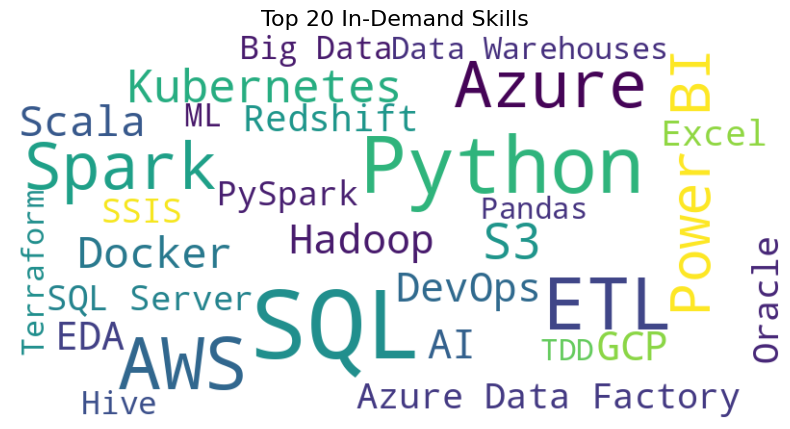

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Count the frequency of each skill
all_skills = [skill for skills_list in df['extracted_skills'] for skill in skills_list]
top_skills = Counter(all_skills).most_common(30)

# Prepare the word cloud input (a dictionary where keys are words and values are their frequencies)
word_frequencies = dict(top_skills)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_font_size=100).generate_from_frequencies(word_frequencies)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title("Top 20 In-Demand Skills", fontsize=16)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Assuming your DataFrame is called 'df' and has 'extracted_skills' and 'cleaned_job_title' columns.

# Step 1: Prepare the skills column by converting the list to a string format
df['skills_string'] = df['extracted_skills'].apply(lambda x: ' '.join(x))

# Step 2: Apply TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=10)  # Adjust max_features if needed
X = vectorizer.fit_transform(df['skills_string'])

# Get the feature names (skills)
feature_names = vectorizer.get_feature_names_out()

# Step 3: Apply KMeans clustering
n_clusters = 5  # Choose an appropriate number of clusters based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Step 4: Function to get top skills for a given job title based on TF-IDF relevance
def get_top_skills_for_job(job_title, top_n=5):
    if job_title not in df['cleaned_job_title'].values:
        return f"OOpssss..!! This job title '{job_title}' not found in the dataset."

    # Get the cluster of the queried job title
    job_title_data = df[df['cleaned_job_title'] == job_title]
    if job_title_data.empty:
        return f"OOpssss..!! This job title '{job_title}' not found in the dataset."

    cluster_of_job = job_title_data['Cluster'].iloc[0]

    # Find the rows corresponding to the job titles in the same cluster
    skills_in_cluster = df[df['Cluster'] == cluster_of_job]['skills_string']

    # Apply TF-IDF transformation to these skills
    X_cluster = vectorizer.transform(skills_in_cluster)

    # Sum the TF-IDF scores across all skills for the cluster
    summed_tfidf_scores = X_cluster.sum(axis=0).A1

    # Create a DataFrame with the feature names (skills) and their summed TF-IDF scores
    skills_with_scores = pd.DataFrame(zip(feature_names, summed_tfidf_scores), columns=['Skill', 'Score'])

    # Sort the skills by score in descending order and return the top N skills as a set
    top_skills = set(skills_with_scores.sort_values(by='Score', ascending=False).head(top_n)['Skill'])

    return top_skills

# Step 5: Function to get top similar job titles for a given job title
def get_similar_job_titles(job_title, n_top=2):
    if job_title not in df['cleaned_job_title'].values:
        return f"OOpssss..!! This job title '{job_title}' not found in the dataset."

    # Get the cluster of the queried job title
    job_title_data = df[df['cleaned_job_title'] == job_title]
    if job_title_data.empty:
        return f"OOpssss..!! This job title '{job_title}' not found in the dataset."

    cluster_of_job = job_title_data['Cluster'].iloc[0]

    # Find job titles in the same cluster
    similar_jobs = df[df['Cluster'] == cluster_of_job]['cleaned_job_title']

    # Exclude the queried job title itself and get the top n similar job titles
    similar_jobs = similar_jobs[similar_jobs != job_title].value_counts().head(n_top)

    return similar_jobs

# Example query for job title "data scientist"
job_title_query = "data scientist"

# Get top skills for the queried job title
top_skills_query = get_top_skills_for_job(job_title_query)
if isinstance(top_skills_query, set):
    print(f"Skills for {job_title_query}: {top_skills_query}")
else:
    print(top_skills_query)  # Handle case where job title is not found

# Get top 2 similar job titles for the queried job title
similar_jobs = get_similar_job_titles(job_title_query)
if isinstance(similar_jobs, pd.Series):
    print(f"\nTop 2 similar job titles to {job_title_query}:")
    for job_title in similar_jobs.index:
        print(f"\n{job_title}:")
        top_skills = get_top_skills_for_job(job_title)
        print(f"Skills: {top_skills}")
else:
    print(similar_jobs)  # Handle case where job title is not found


Skills for data scientist: {'python', 'aws', 'sql', 'etl', 'spark'}

Top 2 similar job titles to data scientist:

data engineer:
Skills: {'python', 'sql', 'azure', 'etl', 'data'}

software engineer:
Skills: {'python', 'sql', 'azure', 'etl', 'data'}


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans

# Calculate silhouette score
sil_score = silhouette_score(X, kmeans.labels_)  # X is your feature set
print(f"Silhouette Score: {sil_score:.2f}")

# Calculate Calinski-Harabasz Index
# Use the actual feature matrix and cluster labels from KMeans
calinski_harabasz = calinski_harabasz_score(X.toarray(), kmeans.labels_)  # Use X.toarray() if X is sparse
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")


Silhouette Score: 0.30
Calinski-Harabasz Index: 1018.98


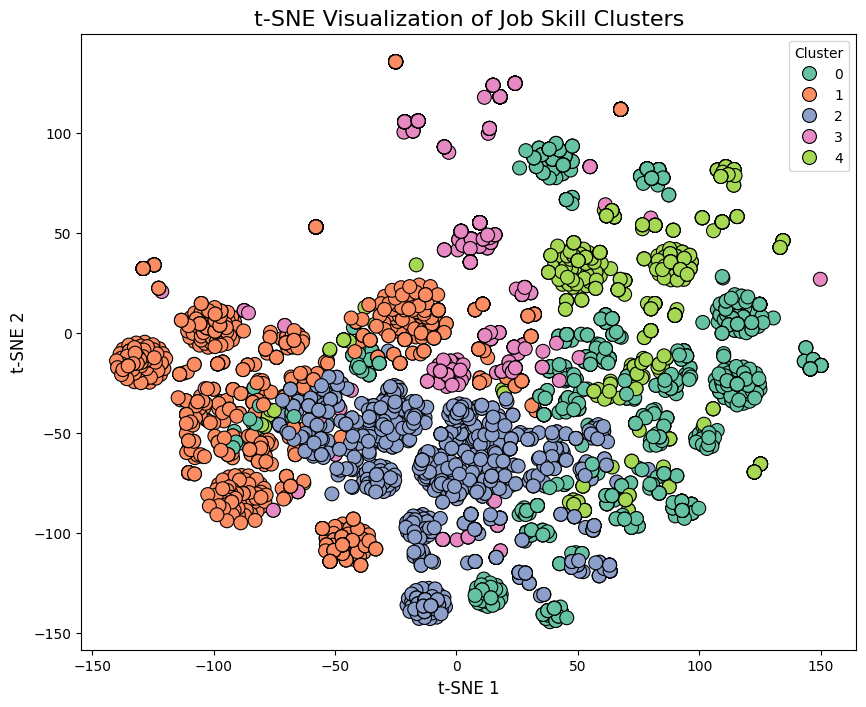

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())  # X is the TF-IDF matrix

# Step 2: Create a DataFrame with the t-SNE coordinates and cluster labels
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE_1', 'TSNE_2'])
df_tsne['Cluster'] = df['Cluster']

# Step 3: Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_tsne, x='TSNE_1', y='TSNE_2', hue='Cluster', palette='Set2', s=100, edgecolor='k', marker='o')

# Step 4: Add title and labels
plt.title('t-SNE Visualization of Job Skill Clusters', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.legend(title='Cluster', loc='upper right')

# Show the plot
plt.show()


In [ ]:
popular_categories = df['cleaned_job_title'].value_counts()[:5]
popular_categories

,count
cleaned_job_title,
data engineer,3172
analyst,1418
data scientist,205
software engineer,142
architect,63


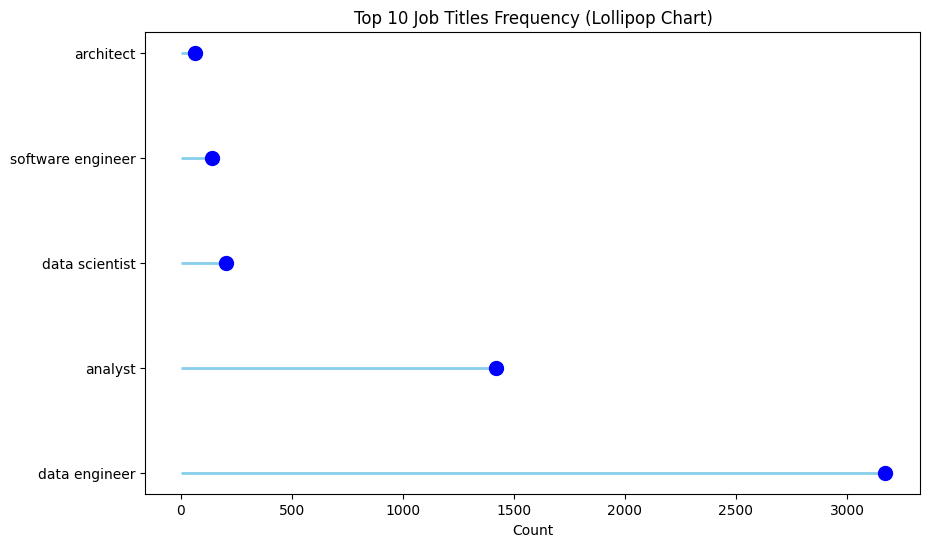

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
frequencies = df['cleaned_job_title'].value_counts().loc[popular_categories.index]

# Plot the lollipop chart
plt.figure(figsize=(10, 6))
plt.hlines(y=frequencies.index, xmin=0, xmax=frequencies, color='skyblue', linewidth=2)
plt.plot(frequencies, frequencies.index, 'o', markersize=10, color='blue')
plt.xlabel("Count")
plt.title("Top 10 Job Titles Frequency (Lollipop Chart)")
plt.show()


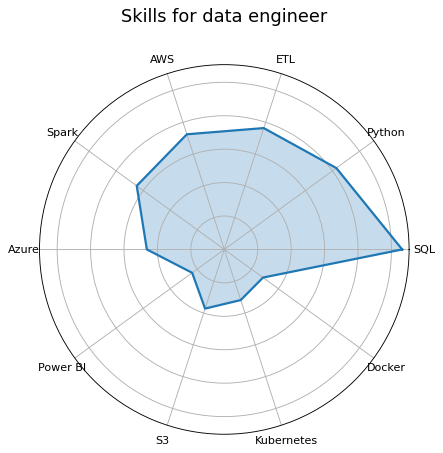

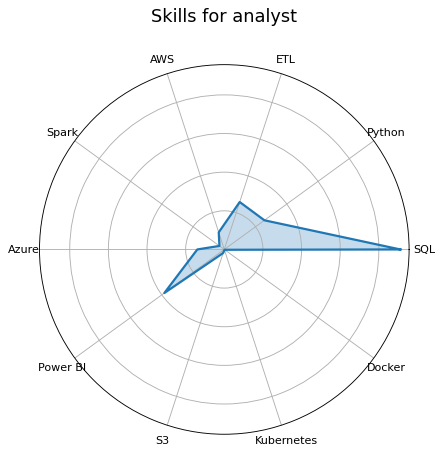

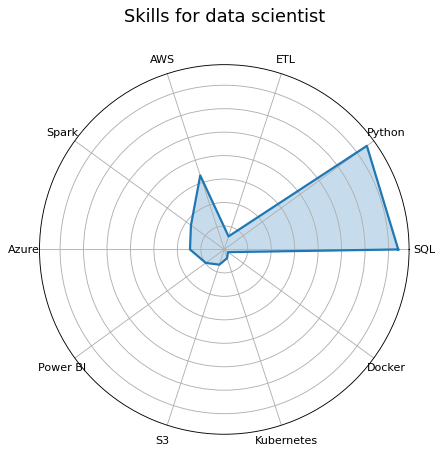

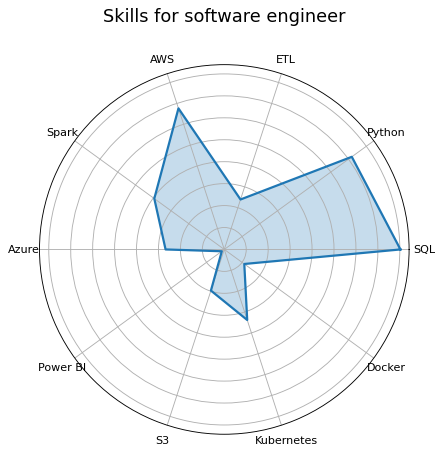

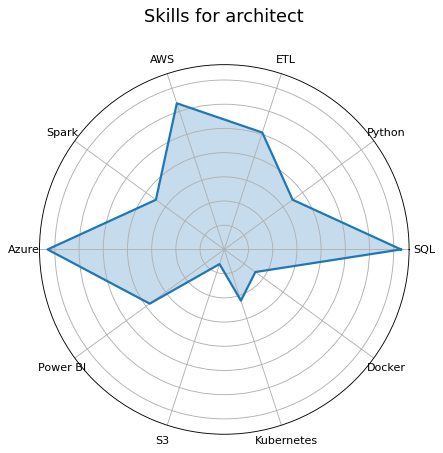

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from math import pi



# Step 1: Get the list of all skills across all job titles
all_skills = [skill for skills_list in df['extracted_skills'] for skill in skills_list]

# Step 2: Count the frequency of each skill and select the top 10
top_skills = Counter(all_skills).most_common(10)
top_skills_list = [skill for skill, _ in top_skills]

# Step 3: Count the frequency of each job title and select the top 10
top_job_titles = Counter(df['cleaned_job_title']).most_common(5)
top_job_titles_list = [job_title for job_title, _ in top_job_titles]

# Step 4: Normalize skill values (i.e., count the presence of top skills per job)
def normalize_skills(skills_list, top_skills):
    return [1 if skill in skills_list else 0 for skill in top_skills]

df['skills_normalized'] = df['extracted_skills'].apply(lambda x: normalize_skills(x, top_skills_list))

# Convert the 'skills_normalized' column to a DataFrame where each column corresponds to a skill
skills_df = pd.DataFrame(df['skills_normalized'].tolist(), columns=top_skills_list)

# Step 5: Create radar chart for each job title
def plot_radar_chart(job_title, skills_values, skills_list):
    num_skills = len(skills_list)

    # Angle for each skill
    angles = np.linspace(0, 2 * np.pi, num_skills, endpoint=False).tolist()

    # Make the chart circular by repeating the first value at the end
    skills_values += skills_values[:1]
    angles += angles[:1]

    # Set up the figure
    fig, ax = plt.subplots(figsize=(6, 6), dpi=80, subplot_kw=dict(polar=True))

    # Plot the data
    ax.plot(angles, skills_values, linewidth=2, linestyle='solid', label=job_title)

    # Fill the area
    ax.fill(angles, skills_values, alpha=0.25)

    # Set labels for each skill
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(skills_list, rotation=45)

    # Set the title in black
    ax.set_title(f"Skills for {job_title}", size=16, color='black', y=1.1)

    plt.show()


# Step 6: Plot radar chart for the top 10 job titles
for job_title in top_job_titles_list:
    job_title_data = df[df['cleaned_job_title'] == job_title]

    # Aggregate the skills for the top job title
    skills_values = skills_df.loc[job_title_data.index].mean(axis=0).tolist()

    plot_radar_chart(job_title, skills_values, top_skills_list)
